# CNN : Baseline model on Resturant data

In [ ]:
# COLAB
from google.colab import files
from google.colab import drive
# SYS
import sys
# IPYNB
!pip install import-ipynb
import import_ipynb
# UTIL
import importlib.util

In [3]:
import pandas as pd
import re
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation , Flatten
from sklearn.preprocessing import LabelEncoder
from keras import utils as np_utils
from tensorflow.keras.layers import Dropout,Embedding , BatchNormalization
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
import xgboost as xgb 
import sklearn.metrics as metrics

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


###  Loading preprocessing class

In [6]:
#https://stackoverflow.com/questions/62117483/import-module-in-google-colab-from-google-drive-python
sys.path.append('/content/gdrive/MyDrive/CS--2/')
from module_2_preprocessing import Data_Preprocessing

Uninstalling nltk-3.2.5:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/nltk-3.2.5.dist-info/*
    /usr/local/lib/python3.6/dist-packages/nltk/*
Proceed (y/n)? y
  Successfully uninstalled nltk-3.2.5
     |████████████████████████████████| 1.4MB 4.2MB/s 
  Created wheel for nltk: filename=nltk-3.5-cp36-none-any.whl size=1434674 sha256=ef5535717769d7e91024d8101b08233cef9108924d63562ae5df0904454e408b
  Stored in directory: /root/.cache/pip/wheels/ae/8c/3f/b1fe0ba04555b08b57ab52ab7f86023639a526d8bc8d384306
Successfully built nltk


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


{"haven't", 'are', 'in', 'when', 'doing', 'but', 'with', 'once', 'between', 'him', 'his', 'more', 'than', 'to', 'not', 'through', "weren't", "doesn't", "isn't", "didn't", 'where', 'if', 'ain', 'no', 'was', 'her', 'above', 'from', 'such', 'own', 'do', 'has', 'aren', 'i', 'itself', "won't", 'wouldn', 'its', 'herself', 'is', 'you', 'he', 'an', 'hasn', 'because', 'am', 'be', 'did', 'as', 'just', 'very', 'there', 'yourselves', 'them', 'the', 'now', 'mightn', 'at', 'whom', 'have', 'o', "wasn't", "mightn't", 'll', "should've", "it's", 'before', 'having', 'hadn', 'here', 'weren', 'our', 'other', 'can', "couldn't", 'won', 'ours', 'again', 'yourself', 'same', 'too', "wouldn't", 'a', 'been', 'into', 'down', 'my', 're', "shouldn't", "you've", 'it', 'then', 'which', 'further', "that'll", "shan't", 'so', 'and', 's', 'ourselves', 'hers', 'under', 'any', 've', 'off', 'only', 'were', 'we', "mustn't", 'out', 'why', 'had', 'themselves', 'against', 'that', 'this', 'she', 'while', 'd', 'himself', 'most', '

## 1.Loading the data

In [7]:
restaurant_data = pd.read_csv("/content/gdrive/MyDrive/CS--2/restaurant_train_data_semeval_14.csv")

In [8]:
restaurant_data.shape

(3044, 5)

In [9]:
restaurant_data.head()

,id,text,aspect_term,aspect_category,polarity
0,3121,but the staff was so horrible to us.,staff,service,negative
1,2777,"to be completely fair, the only redeeming fact...",food,anecdotes/miscellaneous,negative
2,1634,"the food is uniformly exceptional, with a very...",menu,food,positive
3,2534,where gabriela personaly greets you and recomm...,NaN,service,positive
4,583,"for those that go once and don't enjoy it, all...",NaN,anecdotes/miscellaneous,positive


In [10]:
restaurant_data.groupby('aspect_category').size().sort_values(ascending=False)

aspect_category
anecdotes/miscellaneous    1040
food                        870
service                     466
ambience                    387
price                       281
dtype: int64

In [11]:
catagories = restaurant_data['aspect_category'].unique()
catagories , len(catagories)

(array(['service', 'anecdotes/miscellaneous', 'food', 'price', 'ambience'],
       dtype=object), 5)

## 2.Aspect Based Sentiment Analysis

In [13]:
X = restaurant_data['text']
Y = restaurant_data['aspect_category']

### 2.1. Splitting the data 

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [16]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2435,) (2435,)
(609,) (609,)


In [17]:
dp = Data_Preprocessing()

In [18]:
X_train_review = dp.preprocess_text(X_train)

100%|██████████| 2435/2435 [00:02<00:00, 950.60it/s]


In [19]:
X_test_review = dp.preprocess_text(X_test)

100%|██████████| 609/609 [00:00<00:00, 2728.87it/s]


In [20]:
from keras.preprocessing.text import Tokenizer

vocab_size = 6000 # We set a maximum size for the vocabulary
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X)
X_train_tokenized = pd.DataFrame(tokenizer.texts_to_matrix(X_train_review))
X_test_tokenized = pd.DataFrame(tokenizer.texts_to_matrix(X_test_review))

In [21]:
label_encoder = LabelEncoder()
integer_category = label_encoder.fit_transform(y_train)
encoded_y_train = np_utils.to_categorical(integer_category)

integer_category = label_encoder.fit_transform(y_test)
encoded_y_test = np_utils.to_categorical(integer_category)

### 2.2. CNN Aspect catagory Based Model

In [22]:
acbsa_model = Sequential()                                                   
acbsa_model.add(Dense(512, input_shape=(6000,), activation='relu'))
#acbsa_model.add((BatchNormalization()))
acbsa_model.add((Dense(256, activation='relu')))
acbsa_model.add((Dropout(0.3)))
acbsa_model.add((Dense(128, activation='relu')))
#acbsa_model.add((Dropout(0.1)))
#acbsa_model.add((Dense(64, activation='relu')))
acbsa_model.add(Dense(5, activation='softmax'))
#compile model
acbsa_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [23]:
acbsa_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               3072512   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 645       
Total params: 3,237,381
Trainable params: 3,237,381
Non-trainable params: 0
_________________________________________________________________


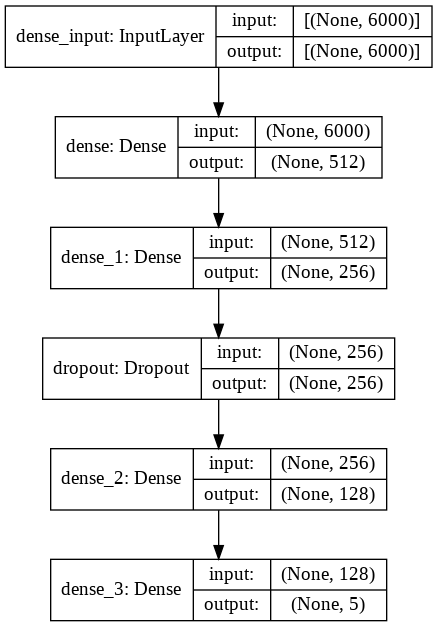

In [24]:
plot_model(acbsa_model, 'model_1.png',show_shapes=True)

In [25]:
#fit aspect classifier
history = acbsa_model.fit(X_train_tokenized , encoded_y_train , validation_data=(X_test_tokenized ,encoded_y_test) , epochs= 5, verbose=1)

Epoch 1/5
77/77 [==============================] - 3s 32ms/step - loss: 1.4250 - accuracy: 0.4085 - val_loss: 1.0152 - val_accuracy: 0.6371
Epoch 2/5
77/77 [==============================] - 2s 25ms/step - loss: 0.5370 - accuracy: 0.8113 - val_loss: 0.9008 - val_accuracy: 0.7225
Epoch 3/5
77/77 [==============================] - 2s 24ms/step - loss: 0.0979 - accuracy: 0.9775 - val_loss: 1.2342 - val_accuracy: 0.7061
Epoch 4/5
77/77 [==============================] - 2s 25ms/step - loss: 0.0139 - accuracy: 0.9998 - val_loss: 1.4049 - val_accuracy: 0.7077
Epoch 5/5
77/77 [==============================] - 2s 24ms/step - loss: 0.0054 - accuracy: 0.9994 - val_loss: 1.4750 - val_accuracy: 0.7094


In [26]:
predicted_cat = label_encoder.inverse_transform(acbsa_model.predict_classes(X_test_tokenized))
#print(new_polarity)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [27]:
predicted_cat[0:10]

array(['price', 'ambience', 'anecdotes/miscellaneous',
       'anecdotes/miscellaneous', 'price', 'anecdotes/miscellaneous',
       'food', 'food', 'food', 'anecdotes/miscellaneous'], dtype=object)

### 2.3 Cassification report

In [28]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted_cat ,target_names=catagories))

                         precision    recall  f1-score   support

                service       0.76      0.51      0.61        75
anecdotes/miscellaneous       0.71      0.83      0.77       204
                   food       0.72      0.79      0.75       183
                  price       0.65      0.52      0.58        63
               ambience       0.68      0.57      0.62        84

               accuracy                           0.71       609
              macro avg       0.70      0.64      0.66       609
           weighted avg       0.71      0.71      0.70       609



### Observation : 
This is the classification report of aspect category based sentiment model showing the orecision, recall, f1_score and support values for all 5 unique catagories with accuracy 60 percent 

In [30]:
import matplotlib.pyplot as plt
def plot_accuracy(history, miny=None):
  acc = history.history['accuracy']
  test_acc = history.history['val_accuracy']
  epochs = range(len(acc))
  plt.plot(epochs, acc)
  plt.plot(epochs, test_acc)
  if miny:
    plt.ylim(miny, 1.0)
  plt.title('accuracy') 
  plt.xlabel('epoch')
  plt.figure()

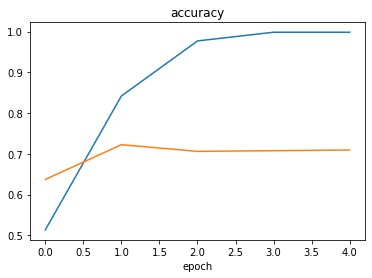

<Figure size 432x288 with 0 Axes>

In [31]:
plot_accuracy(history)

### 2.3. Confusion matrix Representation

In [33]:
# code borrowed from Microsoft Malware Detection Assignment
def plot_confusion_matrix(test_y, predict_y ,labels):
    C = confusion_matrix(test_y, predict_y)      # calculation of confusion matrix 
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y))    # number of misclassified points while predicting y
 
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))

    labels = labels                 
    cmap=sns.light_palette("purple")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))

    # representing B in heatmap format
    print("-"*50, "Recall matrix" , "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

Number of misclassified points  0.29064039408866993
-------------------------------------------------- Confusion matrix --------------------------------------------------


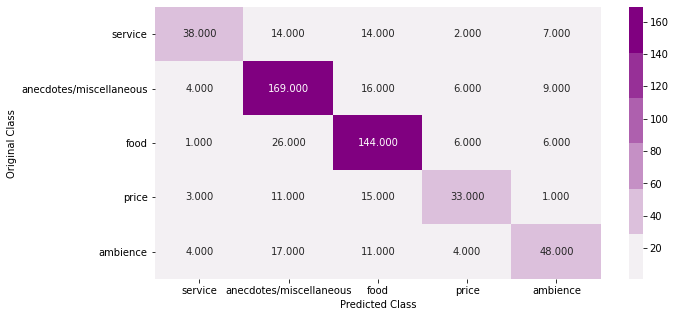

-------------------------------------------------- Precision matrix --------------------------------------------------


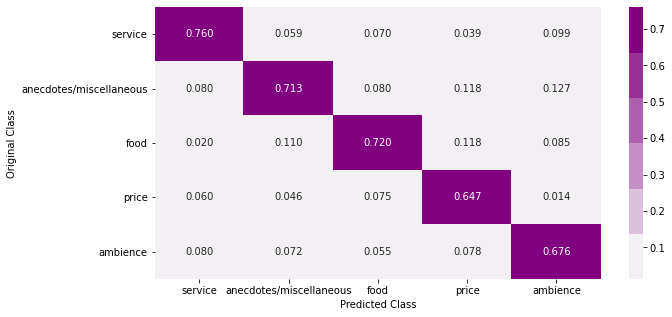

Sum of columns in precision matrix [1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


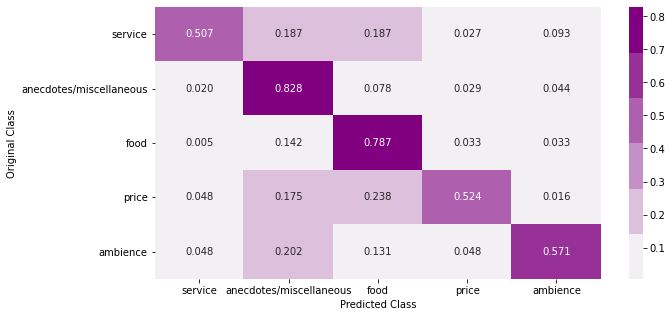

Sum of rows in precision matrix [1. 1. 1. 1. 1.]


In [34]:
plot_confusion_matrix(y_test,  predicted_cat, catagories)

##  3.Polarity Based sentiment model

In [36]:
X = restaurant_data['text']
Y = restaurant_data['polarity']

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [38]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2435,) (2435,)
(609,) (609,)


In [39]:
label_encoder = LabelEncoder()
integer_category = label_encoder.fit_transform(y_train)
encoded_y_train = np_utils.to_categorical(integer_category)

integer_category = label_encoder.fit_transform(y_test)
encoded_y_test = np_utils.to_categorical(integer_category)

### 3.1 CNN Sentiment Model

In [56]:
sentiment_model = Sequential()
sentiment_model.add(Dense(512, input_shape=(6000,), activation='relu'))
#sentiment_model.add((Dense(256, activation='relu')))
sentiment_model.add((Dropout(0.3)))
#sentiment_model.add((Dense(128, activation='relu')))
sentiment_model.add(Dense(4, activation='softmax'))
sentiment_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [41]:
sentiment_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               3072512   
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 516       
Total params: 3,237,252
Trainable params: 3,237,252
Non-trainable params: 0
_________________________________________________________________


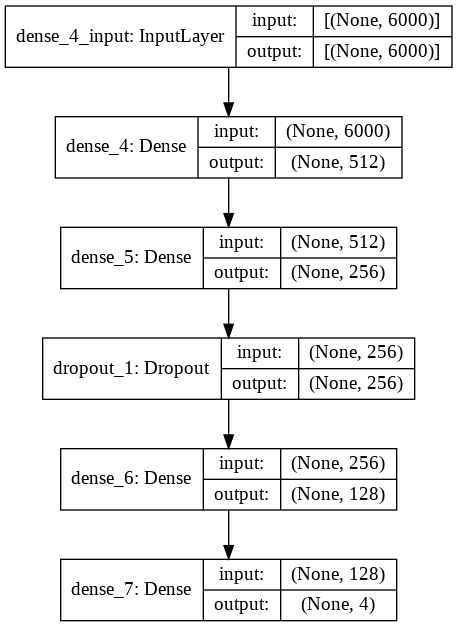

In [42]:
plot_model(sentiment_model, 'model_2.png',show_shapes=True)

In [57]:
#fit aspect classifier
history = sentiment_model.fit(X_train_tokenized , encoded_y_train , validation_data=(X_test_tokenized ,encoded_y_test) , epochs=6, verbose=1)

Epoch 1/6
77/77 [==============================] - 2s 25ms/step - loss: 1.1731 - accuracy: 0.5441 - val_loss: 1.0086 - val_accuracy: 0.5764
Epoch 2/6
77/77 [==============================] - 2s 22ms/step - loss: 0.6845 - accuracy: 0.7272 - val_loss: 0.9675 - val_accuracy: 0.6076
Epoch 3/6
77/77 [==============================] - 2s 22ms/step - loss: 0.3782 - accuracy: 0.8846 - val_loss: 0.9707 - val_accuracy: 0.6404
Epoch 4/6
77/77 [==============================] - 2s 23ms/step - loss: 0.2174 - accuracy: 0.9563 - val_loss: 1.1042 - val_accuracy: 0.6223
Epoch 5/6
77/77 [==============================] - 2s 22ms/step - loss: 0.1233 - accuracy: 0.9804 - val_loss: 1.1523 - val_accuracy: 0.6371
Epoch 6/6
77/77 [==============================] - 2s 23ms/step - loss: 0.0866 - accuracy: 0.9852 - val_loss: 1.2458 - val_accuracy: 0.6388


In [58]:
predicted_polarity = label_encoder.inverse_transform(sentiment_model.predict_classes(X_test_tokenized))
#print(new_polarity)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [59]:
predicted_polarity[0:10]

array(['negative', 'positive', 'neutral', 'positive', 'negative',
       'positive', 'positive', 'neutral', 'negative', 'negative'],
      dtype=object)

In [60]:
polarity = restaurant_data["polarity"].unique()
polarity

array(['negative', 'positive', 'neutral', 'conflict'], dtype=object)

### 3.3 Classification Report

In [61]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted_polarity ,target_names= polarity))

              precision    recall  f1-score   support

    negative       0.42      0.22      0.29        37
    positive       0.58      0.48      0.53       157
     neutral       0.40      0.45      0.43        88
    conflict       0.74      0.81      0.77       327

    accuracy                           0.64       609
   macro avg       0.54      0.49      0.50       609
weighted avg       0.63      0.64      0.63       609



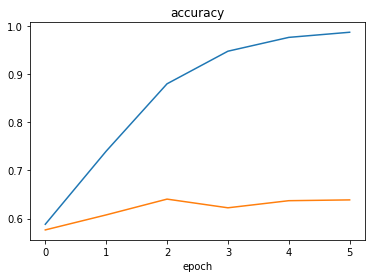

<Figure size 432x288 with 0 Axes>

In [62]:
plot_accuracy(history)

### 3.4. Confusion Matrix Representation

Number of misclassified points  0.361247947454844
-------------------------------------------------- Confusion matrix --------------------------------------------------


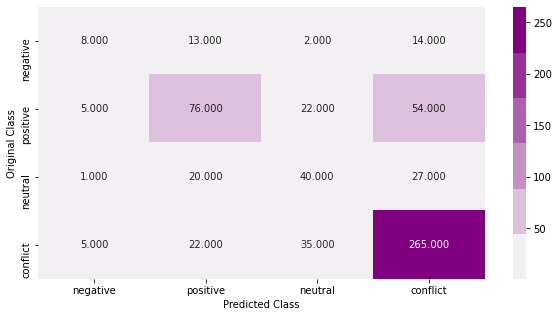

-------------------------------------------------- Precision matrix --------------------------------------------------


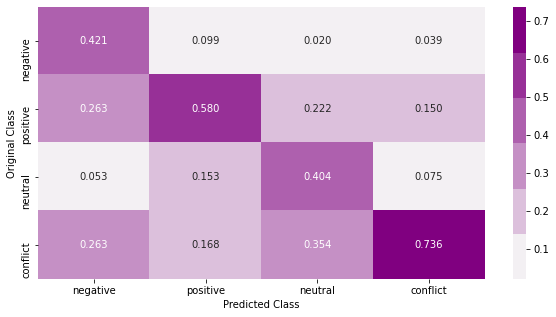

Sum of columns in precision matrix [1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


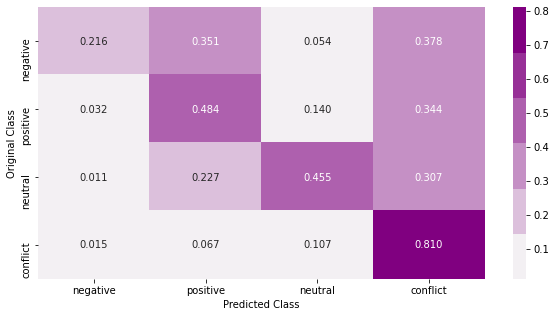

Sum of rows in precision matrix [1. 1. 1. 1.]


In [63]:
plot_confusion_matrix(y_test,  predicted_polarity, polarity)

## 4. creating a resultant dataframe

In [64]:
def create_result_dataframe(pred_1,pred_2):
  # Calling DataFrame constructor on predicted outputs
  resultant_df = pd.DataFrame(list(zip(pred_1,pred_2)), columns = ["predicted_catagories" , "predicted_polarity"])
  result  = pd.crosstab(resultant_df.predicted_catagories,resultant_df.predicted_polarity ,margins = True , margins_name = "Total")
  result["Ranking"] = ( result.Total/resultant_df.shape[0]) * 5.0 
  result["Negative in %"] = (result.negative/result.Total) * 100
  result["Neutral in %"] = (result.neutral/result.Total) * 100
  result["Positive in %"] = (result.positive/result.Total) * 100
  result["conflict in %"] = (result.conflict/result.Total) * 100
  del result["negative"]
  del result["neutral"]
  del result["positive"]
  del result["Total"]
  del result["conflict"]

  return result


In [65]:
result = create_result_dataframe(predicted_cat,predicted_polarity)

In [66]:
result

predicted_polarity,Ranking,Negative in %,Neutral in %,Positive in %,conflict in %
predicted_catagories,,,,,
ambience,0.410509,16.000000,4.000000,76.000000,4.000000
anecdotes/miscellaneous,1.945813,18.143460,30.379747,50.632911,0.843882
food,1.642036,15.000000,11.000000,68.500000,5.500000
price,0.418719,45.098039,3.921569,47.058824,3.921569
service,0.582923,38.028169,1.408451,57.746479,2.816901
Total,5.000000,21.510673,16.256158,59.113300,3.119869


### Observation :
       Above result shows that the Ranking and all Polarities in percentages for all aspect catagories from which we can see that anecdotes/miscellaneous have the highest ranking of 1.94 . and ambience catagory have highest positive polarity